In [76]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.linalg import expm, inv
import time
from pyquil.paulis import *
from pyquil.gates import *
from pyquil import Program, get_qc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pyquil.api import WavefunctionSimulator

In [2]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [3]:
L = 3
Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 2*int(format(j, '0{}b'.format(L))[i])-1
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 2*int(format(j, '0{}b'.format(L))[i])-1 
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

# Exact time evolution

In [4]:
H = sum([Heis[i][(i+1)%L] for i in range(L)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}
# e, v = eigs(H, 30)

# ind = e.argsort()
# e = e[idx]
# v = v[:, idx]
# np.conj(v.T) @ H @ v - np.diag(e), decimals=3)

In [5]:
tf = 50
dt = tf / 200
Nt = int(tf / dt)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c-1]
init = UnitVector(int(''.join(c), 2))
init_prog = Program() + X(1)  # hard coded, be aware <-----------------

In [6]:
revos = [np.zeros(2**L) for i in range(Nt+1)]
revos[0] = init
for i in range(Nt):
    # scipy.sparse.linalg.expm_multiply
    revos[i+1] = expm(-1j * H * dt) @ revos[i]
Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ Sz[0] @ revos[i] / 2)

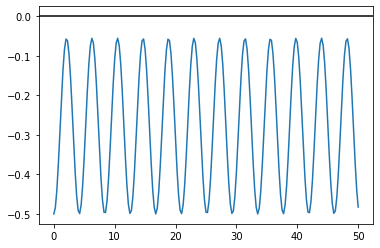

In [7]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

In [64]:
O = Sz[0] # O is any Hermitian operator
p = 1

In [65]:
def Us(params):
    Meven = sp.sparse.identity(2**L)
    Modd = sp.sparse.identity(2**L)
    for i in range(L):
        if (i % 2 != 0):
            Meven = Meven @ expm(-1j * params[i] * Heis[i][(i+1)%L])
        else:
            Modd = Modd @ expm(-1j * params[i] * Heis[i][(i+1)%L])
    return (Meven, Modd)

def K_lt(r, params):
    M = sp.sparse.identity(2**L)
    for i in range(0, r): # is this correct???
        subs_params = params[i*L: (i+1)*L]
        Uevens, Uodds = Us(subs_params)
        M = M @ Uevens @ Uodds
    return M

def K_gt(r, params):
    M = sp.sparse.identity(2**L)
    for i in range(r+1, p):
        subs_params = params[i*L: (i+1)*L]
        Uevens, Uodds = Us(subs_params)
        M = M @ Uevens @ Uodds
    return M

def Chi(r, params):
    return K_gt(r, params) @ init

def S_hat(r, i, params):
    subs_params = params[r*L: (r+1)*L]
    Uevens, Uodds = Us(subs_params)
    return K_lt(r, params) @ Uevens @ Heis[i][(i+1)%L] @ Uodds 

def Ansatz(params):
    M = sp.sparse.identity(2**L)
    for i in range(p):
        subs_params = params[i*L: (i+1)*L]
        Uevens, Uodds = Us(subs_params)
        M = M @ Uevens @ Uodds
    return M

# def A(i, j, m, n, params):
#     _ = 2 * (Chi(m, params).T.conj() @ (S_hat(m, i, params).T.conj() @ O) @ Ansatz(params)).imag 
#     return _ * (Chi(n, params).T.conj() @ (S_hat(n, j, params).T.conj() @ O) @ Ansatz(params)).imag

def A(O, params):
    dim = L * p
    A = []
    ket = Ansatz(params) @ init
    Convert = lambda k: (int(np.floor(k / L)), L-1 if (k+1 % L == 0) else k % L)

    for i in range(dim):
        mdepth, sitei = Convert(i)
        Smdag =  S_hat(mdepth, sitei, params).T.conj()
        Opm = Smdag @ O
        ketm = K_gt(mdepth, params) @ init
        bram = ketm.conj()

        cm = (bram @ Opm @ ket).imag
        vecaux = []

        for j in range(dim):
            ndepth, sitej = Convert(j)
            Sndag = S_hat(ndepth, sitej, params).T.conj()
            Opn = Sndag @ O
            ketn = K_gt(ndepth, params) @ init
            bran = ketn.conj()

            cn = (bran @ Opn @ ket).imag
            vecaux.append(2 * cm * cn)
        
        A.append(vecaux)
    return np.array(A)

# def B(i, m, params):
#     _ = -1 * (Ansatz(params).T.conj() @ (O @ H - H @ O) @ Ansatz(params)).imag # times hbar -- set to 1
#     return _ * (Chi(m, params).T.conj() @ (S_hat(m, i, params).T.conj() @ O) @ Ansatz(params)).imag

def B(O, params):
    dim = L * p
    

In [50]:
# init_params = np.random.uniform(0, 2*np.pi, L*p)
init_params = np.array([0.169101, 0.944882, 2.86183, 2.04611, 0.477759, 5.00422])

A_full = A(Sz[0], init_params)

print(np.around(A_full, decimals=4))
# print(np.dot(np.linalg.inv(A_full), A_full))

[[ 4.2409  0.      0.9164 -1.3887  3.2972  3.2488]
 [ 0.      0.      0.     -0.      0.      0.    ]
 [ 0.9164  0.      0.198  -0.3001  0.7124  0.702 ]
 [-1.3887 -0.     -0.3001  0.4547 -1.0797 -1.0638]
 [ 3.2972  0.      0.7124 -1.0797  2.5634  2.5258]
 [ 3.2488  0.      0.702  -1.0638  2.5258  2.4888]]


In [81]:
pauli_Heis = []
for i in range(L):
    _ = []
    for j in range(L):
        op = sX(i)*sX(j) + sY(i)*sY(j) + sZ(i)*sZ(j)
        _.append(op)
    pauli_Heis.append(_)

pauli_H = sum([pauli_Heis[i][(i+1)%L] for i in range(L)]) * (1/4)

def Us(params):
    Eprog = Program()
    Oprog = Program()
    for i in range(L):
        if (i % 2 != 0):
            Eprog += exponentiate_commuting_pauli_sum(pauli_Heis[i][(i+1)%L])(params[i])
        else:
            Oprog += exponentiate_commuting_pauli_sum(pauli_Heis[i][(i+1)%L])(params[i])
    return (Eprog, Oprog)

def pauli_K_lt(r, params):
    prog = Program()
    for i in range(0, r):
        subs_params = params[i*L: (i+1)*L]
        Eprog, Oprog = Us(subs_params)
        prog += Eprog + Oprog
    return prog

def pauli_K_gt(r, params):
    prog = Program()
    for i in range(r+1, p):
        subs_params = params[i*L: (i+1)*L]
        Eprog, Oprog = Us(subs_params)
        prog += Eprog + Oprog
    return prog

def pauli_Chi(r, params, init): 
    prog = Program() + init
    return prog + pauli_K_gt(r, params)

def pauli_S_hat(r, i, params):
    prog = Program()
    subs_params = params[r*L: (r+1)*L]
    Eprog, Oprog = Us(subs_params)
    prog += pauli_K_lt(r, params) + Eprog
    for _ in pauli_Heis[i][(i+1)%L].get_programs()[0]:
        prog += _
    return prog + Oprog

def pauli_Ansatz(params):
    prog = Program()
    for i in range(p):
        subs_params = params[i*L: (i+1)*L]
        Eprog, Oprog = Us(subs_params)
        prog += Eprog + Oprog
    return prog

def pauli_A(O, params):
    dim = L * p
    A = []
    ket = init_prog + pauli_Ansatz(params)
    Convert = lambda k: (int(np.floor(k / L)), L-1 if (k+1 % L == 0) else k % L)

    for i in range(dim):
        mdepth, sitei = Convert(i)
        Smdag =  pauli_S_hat(mdepth, sitei, params).dagger()
        Opm = Smdag + Z(0) # hard coded
        ketm = pauli_K_gt(mdepth, params) + init_prog
        bram = ketm.conj()

        cm = (bram @ Opm @ ket).imag
        # vecaux = []

        # for j in range(dim):
        #     ndepth, sitej = Convert(j)
        #     Sndag = S_hat(ndepth, sitej, params).dagger()
        #     Opn = Sndag + Z(0) # hard coded
        #     ketn = K_gt(ndepth, params) @ init
        #     bran = ketn.conj()

        #     cn = (bran @ Opn @ ket).imag
        #     vecaux.append(2 * cm * cn)
        
        # A.append(vecaux)
    return np.array(A)

def Fidelity(x, target):
    psi_ansz = pauli_Ansatz(x)
    wfn = wfn_sim.wavefunction(psi_ansz)
    return 1 - abs(np.conj(target) @ wfn.amplitudes)

def Loss(x, target):
    psi_ansz = pauli_Ansatz(x)
    wfn = wfn_sim.wavefunction(psi_ansz)
    Sz_ansz = np.conj(wfn.amplitudes) @ Sz[0] @ wfn.amplitudes / 2
    Sz_ex = np.conj(target) @ Sz[0] @ target / 2
    return abs(Sz_ansz - Sz_ex)

In [82]:
pauli_A(Sz[0], init_params)

AttributeError: 'Program' object has no attribute 'conj'

In [60]:
for p in pauli_Heis[i][(i+1)%L].get_programs()[0]:
    print(p)

X 0
X 1

Y 0
Y 1

Z 0
Z 1



In [13]:
wfn_sim = WavefunctionSimulator()

VarSzList = []
for i in range(1, len(revos)):
    init_params = np.random.uniform(0, 2*np.pi, L*p)
    sol = minimize(Loss, init_params, args=(revos[i]), method='SLSQP')
    bar = pauli_Ansatz(sol.x)
    wfn = wfn_sim.wavefunction(bar)
    VarSzList.append(np.conj(wfn.amplitudes) @ Sz[0] @ wfn.amplitudes / 2)

    if (i % 10 == 0):
        print(i)

10
20
30
40
50


KeyboardInterrupt: 

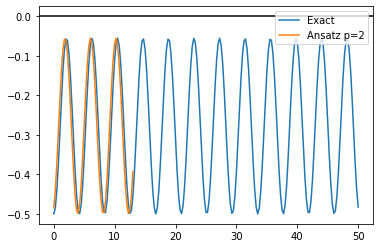

In [14]:
plt.plot([i*dt for i in range(len(revos))], Szt, label='Exact')
plt.plot([i*dt for i in range(len(VarSzList))], VarSzList, label='Ansatz p=2')
plt.legend()
plt.axhline(y=0, color='k')

In [89]:
from qucochemistry.utils import pyquilpauli_to_qubitop
from openfermion.transforms import get_sparse_operator
h = get_sparse_operator(pyquilpauli_to_qubitop(sZ(0)+sX(1)*sX(2)))
h.toarray().real

array([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0., -1.]])

In [15]:
wfn_sim = WavefunctionSimulator()
wfn = wfn_sim.wavefunction(pauli_Ansatz(params, init_prog))
np.around(wfn.amplitudes, decimals=5)
np.conj(wfn.amplitudes) @ Sz[0] @ wfn.amplitudes / 2

(-0.48235814114300374+0j)

In [16]:
psi = Ansatz(params, init)
np.conj(psi) @ Sz[0] @ psi / 2

(-0.4826817612777101+0j)

In [51]:
pauli_Heis

[[(3+0j)*I,
  1.0*X0*X1 + 1.0*Y0*Y1 + 1.0*Z0*Z1,
  (1+0j)*X0*X2 + (1+0j)*Y0*Y2 + (1+0j)*Z0*Z2],
 [(1+0j)*X1*X0 + (1+0j)*Y1*Y0 + (1+0j)*Z1*Z0,
  (3+0j)*I,
  1.0*X1*X2 + 1.0*Y1*Y2 + 1.0*Z1*Z2],
 [1.0*X2*X0 + 1.0*Y2*Y0 + 1.0*Z2*Z0,
  (1+0j)*X2*X1 + (1+0j)*Y2*Y1 + (1+0j)*Z2*Z1,
  (3+0j)*I]]